In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile as siw
from sklearn.model_selection import ParameterGrid

§
from preprocessing import get_audio_and_label, get_spectrogram

from glob import glob
from time import time
from tqdm import tqdm

ModuleNotFoundError: No module named 'sklearn'

In [67]:
def is_silence(filename, downsampling_rate, frame_length_in_s, dbFSthresh, duration_time, frame_step_in_s):
    audio, _, _ = get_audio_and_label(filename)
    spectrogram, _, _ = get_spectrogram(
        filename,
        downsampling_rate,
        frame_length_in_s,
        frame_step_in_s
    )
    dbFS = 20 * tf.math.log(spectrogram + 1.e-6)
    energy = tf.math.reduce_mean(dbFS, axis=1)
    non_silence = energy > dbFSthresh
    non_silence_frames = tf.math.reduce_sum(tf.cast(non_silence, tf.float32))
    non_silence_duration = (non_silence_frames + 1) * frame_length_in_s

    if non_silence_duration > duration_time:
        return 0
    else:
        return 1

In [68]:
is_silence('vad-dataset/silence_016.wav', 16000, 0.04, -150, 0.1)

0

Visualization of the wave: silence vs proper voice

Text(0.5, 0.98, 'Confrontation between voice and silence waves')

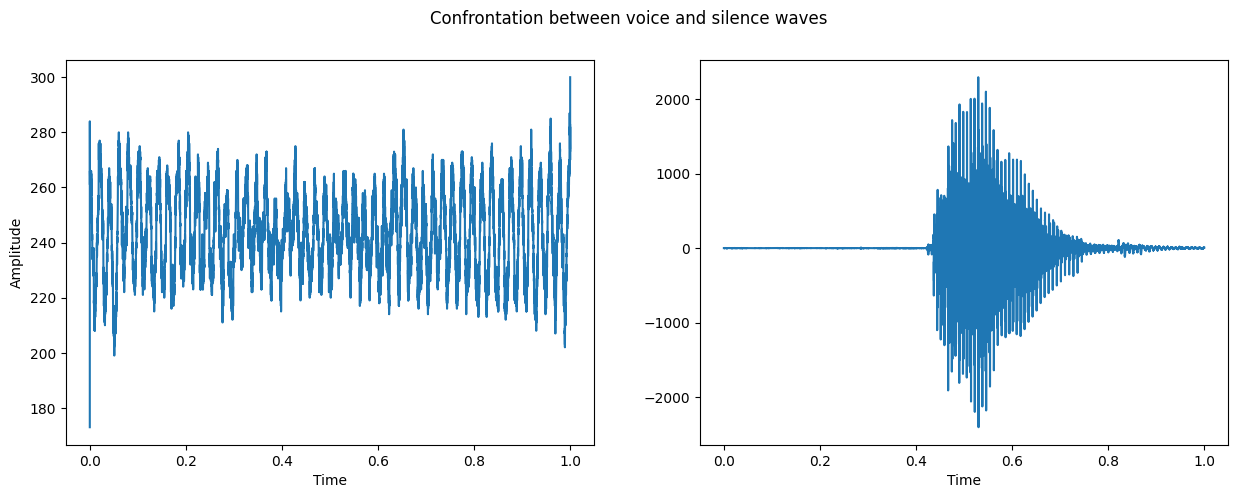

In [99]:
sample_rate_silence, wave_silence = siw.read("vad-dataset/silence_016.wav")
duration = 1
times_silence = np.linspace(0, int(duration), sample_rate_silence*duration)

sample_rate_voice, wave_voice = siw.read("vad-dataset/down_8f4c551f_nohash_3.wav")
times_voice = np.linspace(0, duration, sample_rate_voice*duration)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(times_silence, wave_silence)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Amplitude")
ax[1].plot(times_voice, wave_voice)
ax[1].set_xlabel("Time")
fig.suptitle("Confrontation between voice and silence waves")
plt.show()

/home/francesco/ml4iotvenv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0.98, 'Confrontation between voice and silence waves')

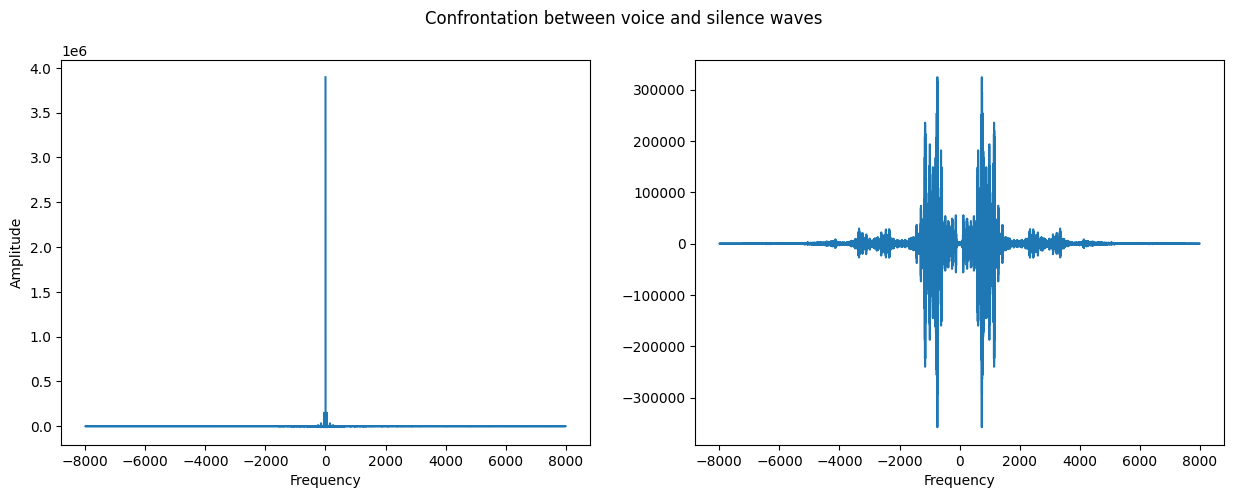

In [102]:
from scipy.fft import fft, fftfreq

frequencies_silence = fftfreq(sample_rate_silence*duration, 1/sample_rate_silence)
y_silence = fft(wave_silence)

frequencies_voice = fftfreq(sample_rate_voice*duration, 1/sample_rate_voice)
y_voice = fft(wave_voice)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(frequencies_silence, y_silence)
ax[0].set_xlabel("Frequency")
ax[0].set_ylabel("Amplitude")
ax[1].plot(frequencies_voice, y_voice)
ax[1].set_xlabel("Frequency")
fig.suptitle("Confrontation between voice and silence waves")

FIRST APPROACH: GENUINE HYPERPARAMETER TUNING

In [69]:
PARAMETERS = {
    "downsampling_rate":[16000, 12000, 10000],
    "frame_length_in_s":[0.4, 0.5, 0.6],
    "dbFStrhesh":[-100, -125, -150],
    "duration_time":[0.01, 0.03, 0.05],
    "frame_step_in_s": [0.6,.7,.8]
}
configurations = {"configurations": []}
my_configs = ParameterGrid(PARAMETERS)
for config in my_configs:
    configurations["configurations"].append(config)

In [70]:
header="downsampling_rate,frame_length_in_s,dbFSthresh,duration_time,accuracy,latency \n"
with open("results_31/10.csv", "w") as csvf_header:
    csvf_header.write(header)

with open("results_31/10.csv", "a") as csvf:
    for idx in tqdm(range(len(configurations["configurations"]))):

        config = configurations["configurations"][idx]
        
        correct = 0
        tot_time = 0
        for filename in glob('vad-dataset/*'):
            audio, sampling_rate, label = get_audio_and_label(filename)
            is_true_silence = label.numpy().decode() == 'silence'

            start = time()
            predicted_silence = is_silence(
                                            filename,
                                            downsampling_rate=config["downsampling_rate"],
                                            frame_length_in_s=config["frame_length_in_s"],
                                            dbFSthresh=config["dbFStrhesh"],
                                            duration_time=config["duration_time"],
                                            frame_step_in_s = config["frame_step_in_s"]
                                            )
            end = time()
            tot_time += end - start 

            if predicted_silence != is_true_silence:
                print(filename, predicted_silence)
            else:
                correct += 1
        
        accuracy = correct / len(glob('vad-dataset/*'))
        time_avg = tot_time / len(glob('vad-dataset/*')) * 1000
        csvf.write(f"{config['downsampling_rate']},{config['frame_length_in_s']},{config['dbFStrhesh']},{config['duration_time']},{accuracy*100},{time_avg:.0f}\n")

100%|██████████| 81/81 [39:53<00:00, 29.55s/it]


In [80]:
df = pd.read_csv("results.csv")


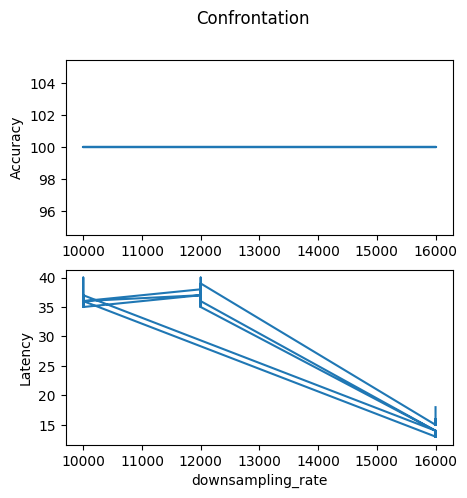

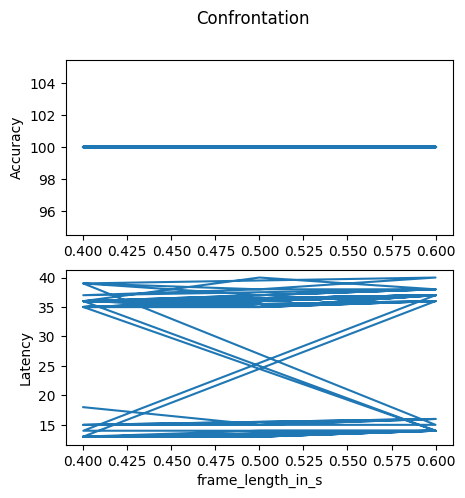

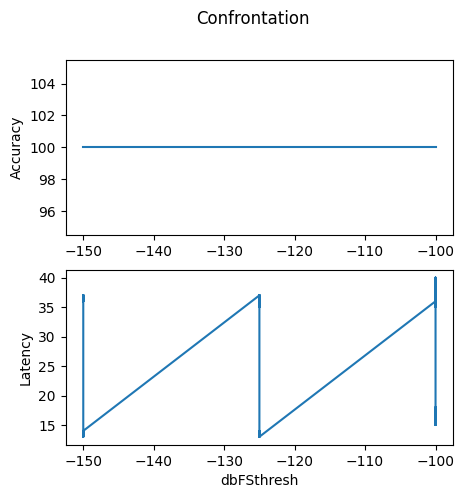

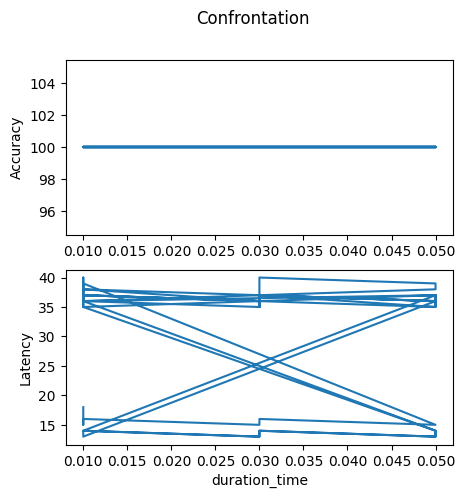

In [81]:
import matplotlib.pyplot as plt

exes = [i for i in range(4)]

for x in exes:
    fig, ax = plt.subplots(2, figsize=(5, 5))
    fig.suptitle("Confrontation")
    ax[0].plot(df.iloc[:, x], df.iloc[:, 4])
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(df.iloc[:, x], df.iloc[:, 5])
    ax[1].set_xlabel(df.columns[x])
    ax[1].set_ylabel("Latency")

SECOND APPROACH: CLEANING THE SIGNAL WITH FFT